In [23]:
%load_ext autoreload
%autoreload 2

import xgboost as xgb
import pandas as pd
import numpy as np
from utils import k_fold_cross_validation_classification, acc_pre_rec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df_train = pd.read_csv('data/data_processed_train_merged.csv')
df_test = pd.read_csv('data/data_processed_test_merged.csv')
df = pd.concat((df_train, df_test), ignore_index=True)

string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)

In [5]:
df

,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,num_travelers,...,num_students,disability,trip_distance,mode,trip_distance_category,age_merged,income_aggregate_merged,res_type_merged,education_merged,travel_date_dow_merged
0,0,0,0,30/05/2019,4,7,2,0,1,1,...,2,3,13.4,subway,long,1,1,0,1,0
1,1,0,1,01/06/2019,6,6,1,0,1,1,...,2,3,3.7,drive,long,1,1,0,1,1
2,2,0,2,02/06/2019,7,7,7,1,2,3,...,2,3,9.8,drive,long,1,1,0,1,1
3,3,0,3,02/06/2019,7,7,7,1,2,3,...,2,3,11.1,drive,long,1,1,0,1,1
4,4,0,4,03/06/2019,1,7,7,0,1,1,...,2,3,2.5,drive,medium,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65733,65787,2991,48,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0
65734,65788,2991,49,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0
65735,65789,2991,50,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0
65736,65790,2991,51,27/06/2019,4,8,8,2,2,4,...,0,4,NaN,NaN,NaN,1,0,2,0,0


In [11]:
candidate_cols = [
#      'travel_date_dow',
#      'o_purpose_category',
     'd_purpose_category',
     'num_non_hh_travelers',
#      'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
     'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
#      'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
     'res_type',
#      'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
#     'trip_distance',
    'res_type_merged',
    'income_aggregate_merged',
    'age_merged',
    'travel_date_dow_merged',
    'education_merged'
]

categorial_columns = ['travel_date_dow', 'o_purpose_category', 'd_purpose_category', 'o_location_type',
                      'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry',
                      'gender', 'survey_language', 'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])

X_train_val = onehot.to_numpy()[:len(df_train)]
group_train_val = df['person_id'].to_numpy()[:len(df_train)]

category = ['short', 'medium', 'long']
y_train_val = df['trip_distance_category'][:len(df_train)].apply(lambda x: category.index(x))

X_test = onehot.to_numpy()[len(df_train):]


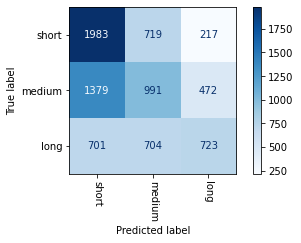

In [28]:
model = xgb.XGBClassifier(objective='multi:softprob',
                          eval_metric='mlogloss',
                          n_estimators = 100,
                          n_jobs=-1,
                          learning_rate= 0.46, # from parameter search
                          max_depth=4,     # from parameter search
                          random_state=42,
                          use_label_encoder =False)

train_metrics, val_metrics = k_fold_cross_validation_classification(X_train_val, y_train_val, group_train_val, model,
                                                                   confusion_matrix_save_path='image/xgboost_dist_confusion.eps',
                                                                   display_labels=['short', 'medium', 'long'])


In [20]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 2, 1, 3]]
train_metrics_df = pd.DataFrame(metrics, columns=['acc-train', 'acc-val', 'logloss-train', 'logloss-val'])
train_metrics_df

,acc-train,acc-val,logloss-train,logloss-val
0,0.542291,0.468627,0.926992,1.018416
1,0.539502,0.472810,0.930190,1.010579
2,0.546569,0.451515,0.925552,1.031719
3,0.544129,0.470022,0.927421,1.010787
4,0.538059,0.470588,0.930623,1.013255


In [ ]:
model.

## Hyperparameter search

In [11]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

model = xgb.XGBClassifier(objective='multi:softprob',
                          eval_metric='mlogloss',
                          n_estimators = 100,
                          n_jobs=-1,
                        
                          random_state=42,
                          use_label_encoder =False)

distributions = {
    'learning_rate': loguniform(10**-5, 1),
    'max_depth': [2, 4, 6, 8]
}

k_fold = GroupKFold(n_splits=5)
search = RandomizedSearchCV(model,
                            distributions,
                            random_state=1,
                            n_jobs=4,
                            scoring='neg_log_loss',
                            n_iter=10,
                            cv=k_fold
                           ).fit(X_train_val, y_train_val, groups=group_train_val)
print('best parameter', search.best_params_)
print('best score', search.best_score_)


/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

best parameter {'learning_rate': 0.46003068044902984, 'max_depth': 4}
best score -1.0137542898665877


In [12]:
search.cv_results_

{'mean_fit_time': array([ 5.91870146, 11.5208704 , 30.34094625, 10.90498581, 11.53934679,
        11.93502722, 21.09745917,  5.46237359, 19.94904089, 16.21032715]),
 'std_fit_time': array([0.0695458 , 1.08618031, 2.6636888 , 0.61754939, 0.44329487,
        0.3230566 , 0.97654233, 0.15054126, 0.3655961 , 3.68618586]),
 'mean_score_time': array([0.01173964, 0.01563993, 0.02482681, 0.0148932 , 0.01527972,
        0.01510205, 0.0217926 , 0.01266828, 0.0196876 , 0.01961098]),
 'std_score_time': array([0.00171996, 0.00262759, 0.00581664, 0.0010475 , 0.00155891,
        0.00108062, 0.00268367, 0.00141046, 0.00086084, 0.00337283]),
 'param_learning_rate': masked_array(data=[0.001216494146415184, 0.46003068044902984,
                    0.00032483503450866794, 0.0001515112512310289,
                    8.536916958038756e-05, 0.022321849928717594,
                    0.004944059287398676, 0.00036844068804921975,
                    0.00010525948689799704, 0.0001405678714738834],
              ma

## train model on whole dataset

In [13]:
## model parameter from search results
model = xgb.XGBClassifier(objective='multi:softprob',
                          eval_metric='mlogloss',
                          n_estimators = 100,
                          n_jobs=-1,
                          learning_rate= 0.46, # from parameter search
                          max_depth=4,     # from parameter search
                          random_state=42,
                          use_label_encoder =False)


model.fit(X_train_val, y_train_val)

### Show probability and ground truth
Well...not that great

In [58]:
# calculate training metrics
y_train_val_proba = model.predict_proba(X_train_val)
pd.DataFrame(np.concatenate((y_train_val_proba, np.array(y_train_val).reshape(-1, 1)), axis=1),
            columns=['prob short', 'prob medium', 'prob_long', 'ground truth'])

,prob short,prob medium,prob_long,ground truth
0,0.028715,0.053526,0.917759,2.0
1,0.194525,0.397987,0.407488,2.0
2,0.213565,0.378102,0.408333,2.0
3,0.213565,0.378102,0.408333,2.0
4,0.340016,0.413909,0.246075,1.0
...,...,...,...,...
39439,0.582804,0.297657,0.119538,0.0
39440,0.582804,0.297657,0.119538,0.0
39441,0.582804,0.297657,0.119538,0.0
39442,0.538093,0.302597,0.159310,1.0


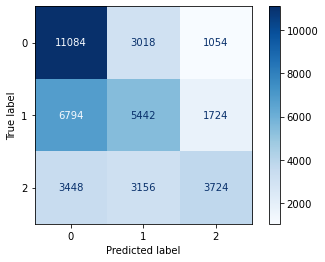

In [64]:
# show confusion metric
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_train_val_pred = model.predict(X_train_val)
ConfusionMatrixDisplay.from_predictions(y_train_val, y_train_val_pred, cmap=plt.cm.Blues
)


## Read test data


In [14]:
y_train_val_proba = model.predict_proba(X_train_val)
y_test_proba = model.predict_proba(X_test)

In [16]:
# Append prediction to dataset
df_train[['trip_distance_short_prob', 'trip_distance_medium_prob', 'trip_distance_long_prob']] = y_train_val_proba
df_test[['trip_distance_short_prob', 'trip_distance_medium_prob', 'trip_distance_long_prob']] = y_test_proba

In [17]:
df_test

,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,num_travelers,...,num_students,disability,age_merged,income_aggregate_merged,res_type_merged,education_merged,travel_date_dow_merged,trip_distance_short_prob,trip_distance_medium_prob,trip_distance_long_prob
0,39498,1795,0,07/06/2019,5,1,6,0,1,1,...,1,4,0,0,2,0,0,0.628514,0.247974,0.123513
1,39499,1795,1,07/06/2019,5,6,6,0,1,1,...,1,4,0,0,2,0,0,0.628514,0.247974,0.123513
2,39500,1795,2,07/06/2019,5,6,1,0,1,1,...,1,4,0,0,2,0,0,0.506205,0.327250,0.166545
3,39501,1796,0,05/06/2019,3,1,6,0,1,1,...,2,4,1,0,2,2,0,0.621488,0.259497,0.119015
4,39502,1796,1,05/06/2019,3,6,7,0,1,1,...,2,4,1,0,2,2,0,0.669279,0.239069,0.091651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26289,65787,2991,48,27/06/2019,4,8,8,2,2,4,...,0,4,1,0,2,0,0,0.763958,0.225183,0.010858
26290,65788,2991,49,27/06/2019,4,8,8,2,2,4,...,0,4,1,0,2,0,0,0.763958,0.225183,0.010858
26291,65789,2991,50,27/06/2019,4,8,8,2,2,4,...,0,4,1,0,2,0,0,0.763958,0.225183,0.010858
26292,65790,2991,51,27/06/2019,4,8,8,2,2,4,...,0,4,1,0,2,0,0,0.763958,0.225183,0.010858


In [18]:
# save test data with trip_distance predictions to file
df_train.to_csv('data/xgboost_distance_classification_prob_merged_train', index=False)
df_test.to_csv('data/xgboost_distance_classification_prob_merged_test', index=False)